# Solving QAP with SA

## QAP
The Quadratic Assignment Problem (QAP) is one of the fundamental combinatorial optimization problems in the branch of optimization or operations research in mathematics, from the family of facility location problems.

The problem models the following real-life scenario: Given a set of facilities and a set of locations, with certain distances between each pair of locations and certain flows between each pair of facilities, the goal is to assign all facilities to different locations in such a way that the sum of the products between flows and distances is minimized. Essentially, it's about matching facilities to locations to minimize the overall cost of the distances multiplied by the flows.

Mathematically, the QAP can be formulated as follows:

Given two matrices $D = [d_{ij}]$ and $F = [f_{kl}]$, where $d_{ij}$ represents the distance between locations $i$ and $j$, and $f_{kl}$ represents the flow between facilities $k$ and $l$, the objective is to find a permutation $\pi$ of $N$ elements that minimizes the objective function:

$$
\sum_{i=1}^{N} \sum_{j=1}^{N} f_{\pi(i)\pi(j)} \cdot d_{ij}
$$

The QAP is known to be NP-hard, which means that no efficient algorithm is known to find the optimal solution for all possible instances of the problem within polynomial time. Therefore, heuristic and metaheuristic algorithms, such as tabu search, genetic algorithms, and simulated annealing, are often used to find approximate solutions.

## SA
Simulated annealing (SA) is a probabilistic technique for approximating the global optimum of a given function. It is useful for the QAP because it allows escaping from local optima by accepting worse solutions with a certain probability, which decreases as the algorithm progresses. This makes it better suited for finding a good approximation in a complex problem landscape like that of the QAP.

The technique is inspired by the physical process of annealing in metallurgy, a process involving heating and controlled cooling of a material to increase the size of its crystals and reduce their defects. The goal is to bring the material to a state with lower internal energy.

Here's how simulated annealing works in the context of optimization:

1. **Initialization**: We start with an initial solution to the problem, usually generated at random. in our case we initialize an array from 1 to $N$ (number of lacations). We also set an initial temperature that is high enough.
2. **Iteration**: At each step, we modify the current solution to generate a new solution. we modify it by suggesting a neighbor which is generated by swapping two (or more) location in the array.
3. **Evaluation and Acceptance**: We then evaluate the new solution. If it is better than the current solution, we accept it as the new current solution. If it is worse, we accept it with a probability that depends on the difference in the quality of the solutions and the current temperature. This probability decreases as the temperature decreases, making the algorithm more selective as it progresses.
4. **Cooling**: We gradually decrease the temperature according to a cooling rate. The cooling schedule is crucial to the performance of the algorithm; it must be slow enough to allow exploration of the search space but fast enough to ensure the algorithm terminates in a reasonable amount of time.
5. **Termination**: Repeat steps 2 through 4 until a stopping criterion is met, typically a fixed number of iterations or a temperature threshold.

Simulated annealing is effective because it allows for a controlled exploration of the search space. Early on, when the temperature is high, the algorithm is more likely to accept worse solutions, which enables it to escape local optima and explore more widely. As the temperature decreases, the algorithm becomes more focused on exploiting the regions of the search space that appear most promising, refining its search around the best solutions found.

Despite its simplicity, simulated annealing has been successfully applied to a wide range of problems, including but not limited to the traveling salesman problem, scheduling, and the quadratic assignment problem. Its effectiveness depends significantly on the choice of the cooling schedule, the method for generating new solutions, and the initial temperature, making the tuning of these parameters a critical aspect of using the algorithm.

In [122]:
# Importing the necessary libraries
import random
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
random.seed(0)
np.random.seed(0)

In [123]:
D = [] #A 2D array to store the distances between locations
F = [] #A 2D array to store the flow between locations
N  = 0 #Number of locations

def getInput(file_name):
    global N, D, F
    with open(f'./QAPdata/{file_name}.dat', 'r') as file:
        # Read lines in the file
        lines = file.readlines()
        N = int(lines[0])
        D = [list(map(int, row.split())) for row in lines[2:N+2] if len(row.split()) > 0]
        F = [list(map(int, row.split())) for row in lines[N+3:] if len(row.split()) > 0]
    return

We have defined a class for each solution with the attribure `sol` which is initialized randomely if there is no predefined solution sequence given to the object. 
- `set_sol()`: This method is used to update the previous solution, if the new generated solution has lower cost or if the the **Metropolis criterion** accepts it.
- `cost()`: this method calculates the cost of the solution based on equation mentioned above.
- `generate_neighbor(x)`: In order to explore the search space, we need to generate new solutions. This method swaps x pairs of randomly selected positions in the solution to generate a neighbor.

In [124]:
class Solution:
    global N, D, F
    def __init__(self, prev_val=[]):
        if prev_val == []:
            self.sol = list([i for i in range(N)])
            random.shuffle(self.sol)
        else:
            self.sol = prev_val

    def set_sol(self, val=[]):
        self.sol = list(val)

    def cost(self):
        fit = int(0)
        for i in range(N):
            for j in range(N):
                fit += D[i][j] * F[self.sol[i]][self.sol[j]]
        return fit

    def generate_neighbor(self, x=1):
        new_sol = list(self.sol)
        for _ in range(x):
            i, j = random.sample(range(0, N), 2)
            new_sol[i], new_sol[j] = new_sol[j], new_sol[i]
        return new_sol

SA algorithm recieves a number of parameters that can be tuned to get better results:
- `Tmin`: Is the lowest the temperature can get and it should always be more than `0` if the metropolis criterion is used.
- `Tmax`: The initial temperature value should be set to a sufficiently high level to allow the algorithm to progress through several iterations effectively.
- `n_it`: number of iterations. For each temperature (T), we iterate `n_it` times until T reaches its minimum value.
- 'cooling_coef': This coefficient ranges between 0 and 1 and is utilized to decrease the temperature. Setting it close to 0 reduces the total number of iterations. If it is too low, the temperature drops rapidly, potentially causing the algorithm to get stuck in a local optimum. Conversely, setting it close to 1 increases the number of iterations, slowing down the temperature cooling process. However, this might extend the overall time needed to run the algorithm, especially when considering the number of locations (N).

In every iteration, a neighboring solution is created by swapping 1 or more elements of x. The swap counts are dependant on `T/Tmax` ratio so the algorihtm chooses neighbors with more swaps in the early iterations and fewer swaps as the it proceeds. Also the cost difference between the newly generated solution (`x_prim`) and the previous solution (`x`) is stored in a variable named `delta_cost`. `x` is replaced by `x_prim` based on the following criterion:

### Metropolis criterion
The Metropolis criterion is a specific application of the Boltzmann probability, adapted for simulated annealing. It was originally developed for Monte Carlo methods in the Metropolis algorithm, which is where it gets its name. The criterion for accepting a new solution, according to the Metropolis criterion, is:

If the new solution is better (i.e., a lower energy/cost) than the current solution, it is always accepted.
If the new solution is worse, it is accepted with a probability

$$P(e,e’,T)=e^{−(e’−e)/kT}$$

This criterion ensures that the search can move away from local optima but becomes increasingly conservative as the process converges, focusing the search in areas of the solution space where the best solutions are located.

In [128]:
# The main algorihtm
def SA(Tmin, Tmax, n_it, cooling_coef):
    x = Solution() 
    best_sol = x
    T = Tmax
    max_cost = float('-inf')
    costs = []

    for i in range(n_it):
        swap_rate = max(0.5 - (T / Tmax) * 0.5, 0.1)  # Ensures at least 0.1
        swap_count = max(int(np.floor(random.uniform(0, swap_rate) * N)), 1)  # At least one swap
        x_prim = Solution(x.generate_neighbor(swap_count))
        delta_cost = x_prim.cost() - x.cost()
        if (delta_cost < 0):
            x.set_sol(x_prim.sol)
        else:
            bolztmanProb = np.exp((-delta_cost)/(T*0.1))
            p = random.uniform(0, 1)
            if p <= bolztmanProb:
                x.set_sol(x_prim.sol)
            best_sol = x
        best_sol = x if x.cost() < best_sol.cost() else best_sol
        #print('object', x.cost())
        costs.append(x.cost())
        T *= cooling_coef
        if T < Tmin:
            print('Stopping Criteria: reached Tmin')
            break
    return costs, best_sol

N: 12
Matrix D: 12 x 12
Matrix F: 12 x 12
Stopping Criteria: reached Tmin
Best Cost: 9552
Best Solution: [6, 4, 11, 1, 0, 2, 8, 10, 9, 5, 7, 3]


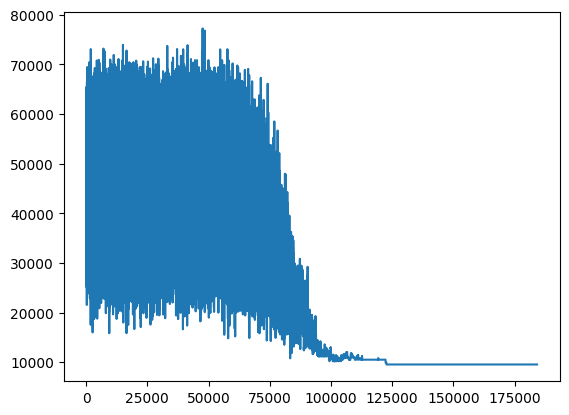

In [129]:
getInput('chr12a')
print("N:", N)
print("Matrix D:", len(D), 'x', len(D[0]))
print("Matrix F:", len(F), 'x', len(F[0]))
C, Sol = SA(Tmin=1, Tmax=1e8, n_it=int(1e10), cooling_coef=1-1e-4)
print("Best Cost:", Sol.cost())
print("Best Solution:", Sol.sol)
plt.plot(range(len(C)), C)

N: 32
Matrix D: 32 x 32
Matrix F: 32 x 32
Stopping Criteria: reached Tmin
Best Cost: 148
Best Solution: [22, 31, 30, 14, 15, 6, 8, 1, 11, 4, 18, 21, 23, 27, 26, 5, 16, 10, 2, 29, 9, 7, 17, 0, 19, 20, 3, 12, 24, 28, 13, 25]


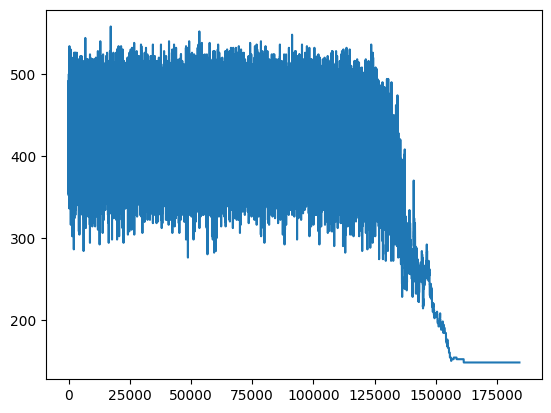

In [130]:
getInput('esc32a')
print("N:", N)
print("Matrix D:", len(D), 'x', len(D[0]))
print("Matrix F:", len(F), 'x', len(F[0]))
C, Sol = SA(Tmin=1, Tmax=1e8, n_it=int(1e10), cooling_coef=1-1e-4)
print("Best Cost:", Sol.cost())
print("Best Solution:", Sol.sol)
plt.plot(range(len(C)), C)

N: 20
Matrix D: 20 x 20
Matrix F: 20 x 20
Stopping Criteria: reached Tmin
Best Cost: 2570
Best Solution: [17, 13, 9, 2, 8, 3, 1, 11, 10, 15, 18, 14, 19, 7, 12, 16, 4, 6, 0, 5]


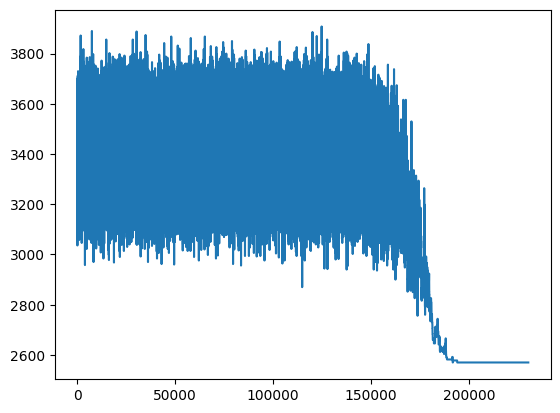

In [139]:
getInput('nug20')
print("N:", N)
print("Matrix D:", len(D), 'x', len(D[0]))
print("Matrix F:", len(F), 'x', len(F[0]))
C, Sol = SA(Tmin=1, Tmax=1e10, n_it=int(1e10), cooling_coef=1-1e-4)
print("Best Cost:", Sol.cost())
print("Best Solution:", Sol.sol)
plt.plot(range(len(C)), C)

N: 30
Matrix D: 30 x 30
Matrix F: 30 x 30
Stopping Criteria: reached Tmin
Best Cost: 1846004
Best Solution: [20, 17, 8, 11, 6, 21, 1, 28, 13, 4, 7, 27, 22, 2, 16, 5, 0, 12, 29, 23, 9, 10, 15, 24, 26, 18, 14, 19, 3, 25]


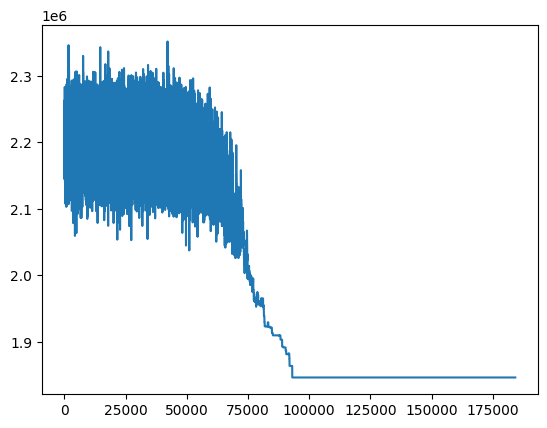

In [132]:
getInput('tai30a')
print("N:", N)
print("Matrix D:", len(D), 'x', len(D[0]))
print("Matrix F:", len(F), 'x', len(F[0]))
C, Sol = SA(Tmin=1, Tmax=1e8, n_it=int(1e10), cooling_coef=1-1e-4)
print("Best Cost:", Sol.cost())
print("Best Solution:", Sol.sol)
plt.plot(range(len(C)), C)

N: 50
Matrix D: 50 x 50
Matrix F: 50 x 50
Stopping Criteria: reached Tmin
Best Cost: 62827
Best Solution: [32, 47, 21, 24, 33, 17, 3, 6, 27, 23, 8, 10, 25, 16, 7, 37, 12, 14, 36, 26, 1, 2, 30, 35, 34, 19, 44, 46, 18, 11, 31, 39, 40, 28, 49, 38, 15, 5, 0, 13, 48, 43, 4, 45, 20, 22, 42, 41, 9, 29]


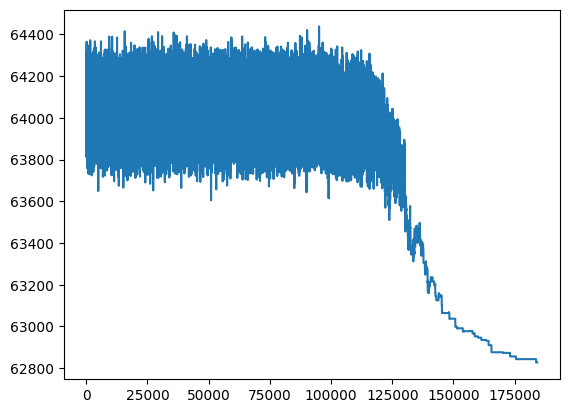

In [133]:
getInput('lipa50a')
print("N:", N)
print("Matrix D:", len(D), 'x', len(D[0]))
print("Matrix F:", len(F), 'x', len(F[0]))
C, Sol = SA(Tmin=1, Tmax=1e8, n_it=int(1e10), cooling_coef=1-1e-4)
print("Best Cost:", Sol.cost())
print("Best Solution:", Sol.sol)
plt.plot(range(len(C)), C)